In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import io
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import toml
import glob
import h5py
from qd_analysis.fig import setup_plotting_env
from markovids.depth.moments import im_moment_features
from tqdm.auto import tqdm

/home/jmarkow/miniconda3/envs/microscopy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from scipy.spatial.transform import Rotation as R

In [4]:
import re

In [5]:
from joblib import Parallel, delayed
import pandas as pd
import seaborn as sns

In [6]:
import nd2

In [7]:
from scipy.ndimage import center_of_mass

In [8]:
def get_rotation_angle(use_im, threshold=300, decimate=2):

    h, w = use_im.shape
    y, x = np.where(use_im > threshold)
    coord_mat = np.vstack([x[::decimate], y[::decimate]]).T.astype("float32")
    
    cx, cy = coord_mat.mean(axis=0)
    # (comy, comx) = center_of_mass(use_im)

    coord_mat[:,0] -= cx
    coord_mat[:,1] -= cy 
    # coord_mat_centered = coord_mat - coord_mat.mean(axis=0, keepdims=True)
    
    cov = np.cov(coord_mat, rowvar=False)
    eigs, eigsv = np.linalg.eig(cov_mat)
    alpha = np.degrees(np.arctan(eigsv[1][1] / eigsv[0][1]))
    beta = 90 - alpha
    # rot_mat = np.hstack([coord_mat, np.ones((coord_mat.shape[0], 1))])
    rotate_angle = beta + 180
    
    return rotate_angle, (cx, cy)

def get_rotation_angle_moments(use_im, threshold=None, decimate=2):
    # cim = use_im.copy()
    # cim[cim<100] = 0
    if threshold is None:
        threshold = np.percentile(use_im[use_im>0], 97.5)
    contours, hierarchy = cv2.findContours((use_im > threshold).astype("uint8"), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(_cnt) for _cnt in contours]
    largest_contour = np.argmax(areas)
    features = im_moment_features(contours[largest_contour])
    return np.rad2deg(features["orientation"]), features["centroid"]


def get_rotated_and_centered_image(
    use_im, bbox_size=(2500, 6000), peak_threshold=None, peak_crop=True, peak_smooth=(10, 10), angle_only=True, **kwargs
):
    h, w = use_im.shape

    if peak_crop:
        c_im = use_im.copy()
        
        if peak_threshold is None:
            threshold = np.percentile(use_im[use_im>0], 95)
            # threshold=600
            # threshold = 500
        
        contours, hierarchy = cv2.findContours((use_im > threshold).astype("uint8"), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        areas = [cv2.contourArea(_cnt) for _cnt in contours]
        largest_contour = np.argmax(areas)
        features = im_moment_features(contours[largest_contour])
        px, py = features["centroid"]
        py = np.round(py).astype("int")
        px = np.round(px).astype("int")
        
        bbox_w = bbox_size[0] // 2
        bbox_h = bbox_size[1] // 2
        bottom = np.maximum(py - bbox_h, 0)
        top = np.minimum(py + bbox_h, h)
        left = np.maximum(px - bbox_w, 0)
        right = np.minimum(px + bbox_w, w)
        use_im = use_im[bottom:top, left:right]
    
    h, w = use_im.shape
    
    # rotate_angle, (cx, cy) = get_rotation_angle(use_im, **kwargs)
    rotate_angle, (cx, cy) = get_rotation_angle_moments(use_im)
    
    M_rotate = cv2.getRotationMatrix2D((cx, cy), 90 - rotate_angle, 1.0)
    M_rotate = np.append(M_rotate, [[0, 0, 1]], axis=0)

    if angle_only:
        M_warp = M_rotate
    else:
        ty = -(cy - h // 2)
        tx = -(cx - w // 2)
        M_translate = np.array([[1.0, 0.0, tx], [0.0, 1.0, ty], [0.0, 0.0, 1]])
        M_warp = M_rotate @ M_translate
    rotated = cv2.warpAffine(use_im, M_warp[:2, :], (w, h), borderValue=use_im[:,:100].mean())
    return rotated, M_warp, use_im

In [9]:
import cmocean

In [10]:
# cmap = plt.matplotlib.colormaps.get_cmap("turbo").copy()
cmap = cmocean.cm.thermal.copy()
cmap.set_bad([0,0,0,1])

In [11]:
data_dir = "/home/jmarkow/data_dir/active_projects/quantum_dots/histology/"

In [12]:
data_files = sorted(glob.glob(os.path.join(data_dir, "*.nd2")))
data_files = [_file for _file in data_files if "BF" not in _file]

In [13]:
store_dat = {}
for _file in tqdm(data_files):
    key = os.path.basename(_file)
    with nd2.ND2File(_file) as f:
        im = f.asarray()
        metadata = f.metadata
        voxel_size = f.voxel_size() # in microns... gives microns per pixel in x, y, and z
    
    rotated, M_warp, crop_im = get_rotated_and_centered_image(im)
    rotated = rotated.astype("float32")
    store_dat[key] = {}
    store_dat[key]["rotated_im"] = rotated
    store_dat[key]["y_profile"] = np.nanmean(rotated, axis=1)
    store_dat[key]["x_profile"] = np.nanmean(rotated, axis=0)
    store_dat[key]["x_voxel_size"] = voxel_size.x
    store_dat[key]["y_voxel_size"] = voxel_size.y
    

100%|███████████████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.02s/it]


In [14]:
setup_plotting_env()

In [15]:
epidermis_side = {
    "QD_perfusion_01_back_C_01_Cy7_10X.nd2": "r",
    "QD_perfusion_01_back_C_10X.nd2": "r",
    "QD_perfusion_01_back_V_10X.nd2": "l",
    "QD_perfusion_02_back_C_01_10X.nd2": "r",
    "QD_perfusion_02_back_C_10X.nd2": "r",
    "QD_perfusion_02_back_V_anterior_10X.nd2": "l",
    "QD_perfusion_02_back_V_posterior_10X.nd2": "r"
}

In [17]:
save_dir = "/mnt/data/jmarkow/panels/2024-06 (QD paper)"

/tmp/ipykernel_3817/1929730317.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


QD_perfusion_01_back_C_01_Cy7_10X.nd2
QD_perfusion_01_back_C_10X.nd2
QD_perfusion_01_back_V_10X.nd2
QD_perfusion_02_back_C_01_10X.nd2
QD_perfusion_02_back_C_10X.nd2
QD_perfusion_02_back_V_anterior_10X.nd2
QD_perfusion_02_back_V_posterior_10X.nd2


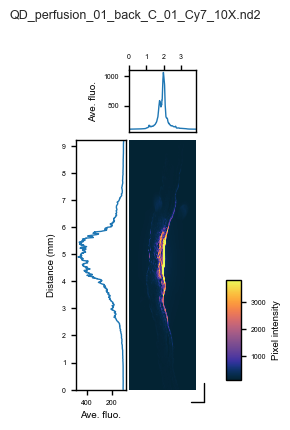

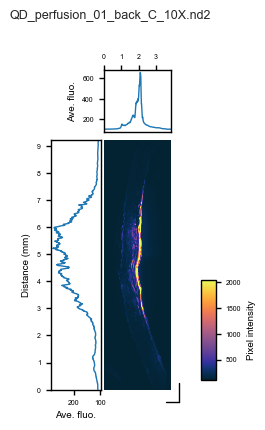

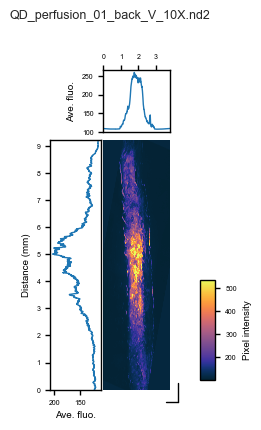

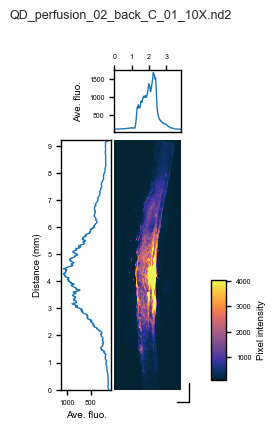

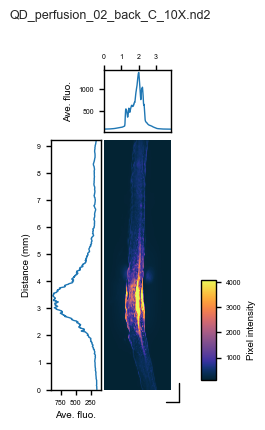

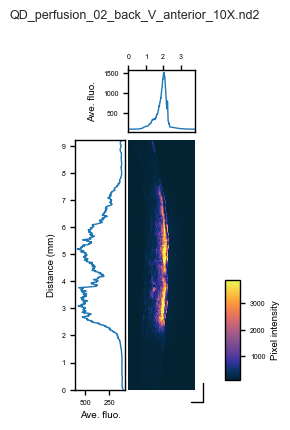

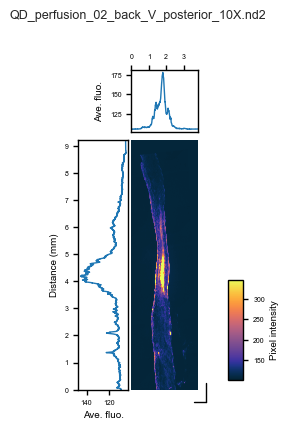

In [18]:
for k, v in store_dat.items():
    rotated = v["rotated_im"].copy()
    
    if epidermis_side[k] == "l":
        rotated = cv2.rotate(rotated, cv2.ROTATE_180)

    x_profile = rotated.mean(axis=0)
    y_profile = rotated.mean(axis=1)
    store_dat[k]["x_profile"] = x_profile
    store_dat[k]["y_profile"] = y_profile
    
    h, w = rotated.shape
    clims = np.nanpercentile(rotated, 5), np.nanpercentile(rotated, 99.5)
    
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
    fig = plt.figure(figsize=(1.5, 4))
    gs = fig.add_gridspec(
        2,
        2,
        height_ratios=(1, 4),
        width_ratios=(.75, 1),
        left=0.1,
        right=0.9,
        bottom=0.1,
        top=0.9,
        wspace=0.05,
        hspace=0.05,
    )
    # Create the Axes.
    xvec = (np.arange(rotated.shape[1]) / voxel_size.x) / 1e3
    yvec = (np.arange(rotated.shape[0]) / voxel_size.y) / 1e3
    
    ax = fig.add_subplot(gs[1,1])
    ax_histx = fig.add_subplot(gs[0,1])
    ax_histx.plot(xvec, x_profile)
    # ax_histx.set_xlabel("Distance (µm)")
    ax_histx.set_ylabel("Ave. fluo.")
    ax_histx.set_xticks(np.arange(0, 4))
    ax_histx.set_xlim(0, xvec[-1])
    ax_histx.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    
    ax_histy = fig.add_subplot(gs[1,0])
    ax_histy.plot(y_profile, yvec)
    ax_histy.set_ylabel("Distance (mm)")
    ax_histy.set_xlabel("Ave. fluo.")
    ax_histy.set_yticks(np.arange(0, 12))
    # ax_histy.set_xlim(100, 300)
    ax_histy.invert_xaxis()
    ax_histy.set_ylim(0, yvec[-1])
    
    h_im =ax.imshow(rotated[::-1], cmap=cmap, vmin=clims[0], vmax=clims[1], aspect="auto")
    
    # add scale bar, burn in image?
    
    x_anchor = w + 300
    y_anchor = h + 300
    
    scale_bar_width = 300 / voxel_size.x
    scale_bar_height = 300 / voxel_size.y
    
    scalex = plt.Line2D([x_anchor - scale_bar_width, x_anchor], [y_anchor] * 2, lw=1., color='k', alpha=1.0, clip_on=False)
    scaley = plt.Line2D([x_anchor]*2 , [y_anchor - scale_bar_height, y_anchor], lw=1., color='k', alpha=1.0, clip_on=False)
    ax.add_line(scalex)
    ax.add_line(scaley)
    fig.suptitle(k, fontsize=9, y=1.05)
    fig.tight_layout()
    
    cb_ax = fig.add_axes([1.1,.124,.1,.25])
    fig.colorbar(h_im, cax=cb_ax, orientation="vertical", label="Pixel intensity")
    print(k)
    
    ax.axis("off")
    fig.savefig(os.path.join(save_dir, f"{k}.pdf"), bbox_inches="tight", dpi=600)
    # scale bar

In [19]:
all_x_profiles = [v["x_profile"] for v in store_dat.values()]
all_y_profiles = [v["y_profile"] for v in store_dat.values()]

In [21]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

In [22]:
# TODO:
# 1. organize by vascular/cell label
# 2. indicate mouse?

In [23]:
clip_length = 1

In [24]:
align = "crossing"
direction = "x"

(-2, 0.5)


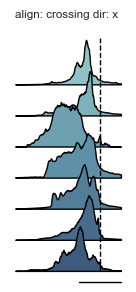

In [25]:
fig, ax = plt.subplots(len(all_x_profiles), 1, figsize=(1.5, 3), sharex=True, sharey=True)

if direction == "x" and align == "peak":
    clip_limits = (-1.5, 1.5)
elif direction == "x" and align == "crossing":
    clip_limits = (-2, .5)
elif direction == "y" and align == "peak":
    clip_limits = (-4, 4)
elif direction == "y" and align == "crossing":
    clip_limits = (-.5, 7)

print(clip_limits)
for _ax, (_key, _value), _color in zip(ax, store_dat.items(), pal):
    # prof here
    _profile = _value[f"{direction}_profile"]
    maxmin = (_profile - min(_profile)) / (max(_profile) - min(_profile))
    zprofile = (_profile - _profile.mean()) / _profile.std()
    # com = center_of_mass(_profile)
    if align == "peak":
        align_point = _profile.argmax()
        # align_point = center_of_mass(_profile)
    elif align == "crossing":
        align_point = max(np.flatnonzero(zprofile > 0))

    xvec = np.arange(len(maxmin)) - align_point
    xvec = (xvec / _value[f"{direction}_voxel_size"])
    xvec /= 1e3

    clip = min(np.flatnonzero(xvec>=clip_limits[0])), max(np.flatnonzero(xvec<=clip_limits[1]))
    
    # also align to threshold crossing to get edge of tissue.
    _ax.fill_between(xvec[clip[0]:clip[1]], maxmin[clip[0]:clip[1]], alpha=1, lw=1, ec="k", clip_on=False, fc=_color)

for _ax in ax:
    _ax.set_yticks([]) 
    _ax.set_clip_on(False)
    _ax.set_xticks([])
    _ax.axis("off")
    _ax.set_ylim([0,1])

# add scale bar here
ax[-1].plot([0, 0],[0, len(all_x_profiles) * .75], clip_on=False, color="k", ls="--")
ax[-1].plot([-.5, .5],[-.25, -.25], color="k", clip_on=False)
fig.subplots_adjust(hspace=-.3)
fig.suptitle(f"align: {align} dir: {direction}")
fig.savefig(os.path.join(save_dir, f"histology_density_align-{align}_direction-{direction}_scale-1mm.pdf"), bbox_inches="tight")

In [102]:
# https://math.stackexchange.com/questions/3832914/need-find-finding-sample-standard-deviation-from-histogram
# https://www.mathworks.com/matlabcentral/answers/1873457-standard-deviation-of-an-histogram?s_tid=prof_contriblnk
def get_spread(dat, voxel_size=voxel_size.x):
    # get CoM
    xs = np.arange(len(dat)) * voxel_size
    mu = np.sum(xs * dat) / np.sum(dat)
    std = np.sqrt(np.sum(dat * (xs - mu) ** 2) / np.sum(dat))
    return std

In [140]:
def get_spread(dat, xs):
    px = dat.copy()
    px /= px.sum()
    mu = xs.dot(px)
    stdx = np.sqrt((xs**2).dot(px) - mu ** 2) 
    return stdx

In [151]:
xspread = [get_spread(_, np.arange(len(_)) * voxel_size.x) * 2 for _ in all_x_profiles]
yspread = [get_spread(_, np.arange(len(_)) * voxel_size.y) * 2 for _ in all_y_profiles]

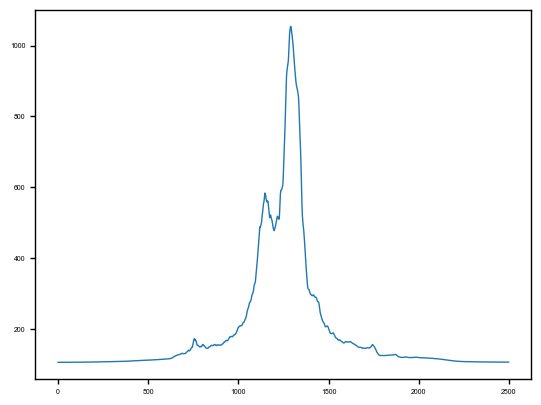

In [152]:
plt.plot(all_x_profiles[0])

In [153]:
stats_dct = {
    "n": len(xspread),
    "depth": {"mean": np.mean(xspread), "std": np.std(xspread)},
    "width": {"mean": np.mean(yspread), "std": np.std(yspread)}
}

In [154]:
with open(os.path.join(save_dir, "stats_histology_spread.toml"), "w") as f:
    toml.dump(stats_dct, f)